In [1]:
%matplotlib inline 
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina' # I use a HiDPI screen

In [2]:
from fishchips.experiments import CMB_Primary
from fishchips.cosmo import Observables
import fishchips.util
from classy import Class  # CLASS python wrapper
import numpy as np
import matplotlib.pyplot as plt

First, we copy and paste code from the Basic Planck Example.

In [3]:
# create an Observables object to store information for derivatives

pars = np.array( ['omega_b','omega_dmeff', 'h',  'A_s', 'n_s', 'tau_reio','sigma_dmeff'])
centers = np.array([0.0224, 0.12,      0.69,  2.2e-9, 0.96, 0.07, 0])

steps = np.array([0.0001,     0.001,    0.01,   0.01e-9, 0.005, 0.02, 2e-26])

fisher = [[2541344108.038636, -487335175.1650552, -135819256.2122977, 2.02071926410754e+16, 54818695.15853991, -85954674.42374833, -1.7887344704859805e+30], [-487335175.1650552, 191753639.00562784, 49339990.81445541, -4201492357878549.5, -8448333.133660374, 18076151.6704248, 2.1443580673638813e+28], [-135819256.2122977, 49339990.81445542, 13151932.5773979, -957163264536608.1, -2204352.657204268, 4032628.7598444205, 8.719858271299403e+27], [2.0207192641075396e+16, -4201492357878549.5, -957163264536608.1, 5.319720064847968e+23, 1002879514557355.2, -2271511458593777.0, -4.1884995170302195e+37], [54818695.15853991, -8448333.133660374, -2204352.657204268, 1002879514557355.2, 2330385.549230009, -4297882.667672092, -9.664428904286152e+28], [-85954674.42374833, 18076151.6704248, 4032628.7598444205, -2271511458593777.0, -4297882.667672091, 9751016.687015843, 1.7757603406957102e+29], [-1.7887344704859803e+30, 2.144358067363883e+28, 8.719858271299403e+27, -4.1884995170302195e+37, -9.664428904286152e+28, 1.7757603406957102e+29, 4.9609868045116285e+51]]

cov = np.linalg.inv(fisher)
#fishchips.util.plot_triangle(obs, cov);

# Arbitrary Priors

We use arbitrary priors by sampling and then plotting triangle plots with corner.py.

In [4]:
import corner

def unitize_cov(imp_cov, scales):
    imp_cov = imp_cov.copy()
    npar = imp_cov.shape[0]
    for i in range(npar):
        for j in range(npar):
            imp_cov[i,j] *= scales[i] * scales[j]
    return imp_cov

def get_samps(inp_cov, inp_means, num=int(1e8)):
    """
    Generate samples from a covariance matrix and input means.
    
    Parameters
    ----------
        inp_cov (2D numpy array) : covariance matrix from Fisher
        inp_means (1D numpy array) : mean values (mu), fiducial from Fisher
        
    Returns
    -------
        2D numpy array with each row corresponding to one random draw 
        from the multivariate Gaussian
    """
    samps = np.random.multivariate_normal( np.array(inp_means)/np.sqrt(np.diag(inp_cov)), 
                                           unitize_cov(inp_cov,1./np.sqrt(np.diag(inp_cov))), int(1e7))
    samps = samps[samps.T[-1]>0]
    for i in range(inp_cov.shape[0]):
        samps.T[i] *= np.sqrt(inp_cov[i,i])
        
    return samps


For example, we can just make the same plot we had just made, but this time with sampling.

In [5]:
unmodified_samples = get_samps(cov, centers)

In [6]:
unmodified_samples.shape

(4998488, 7)

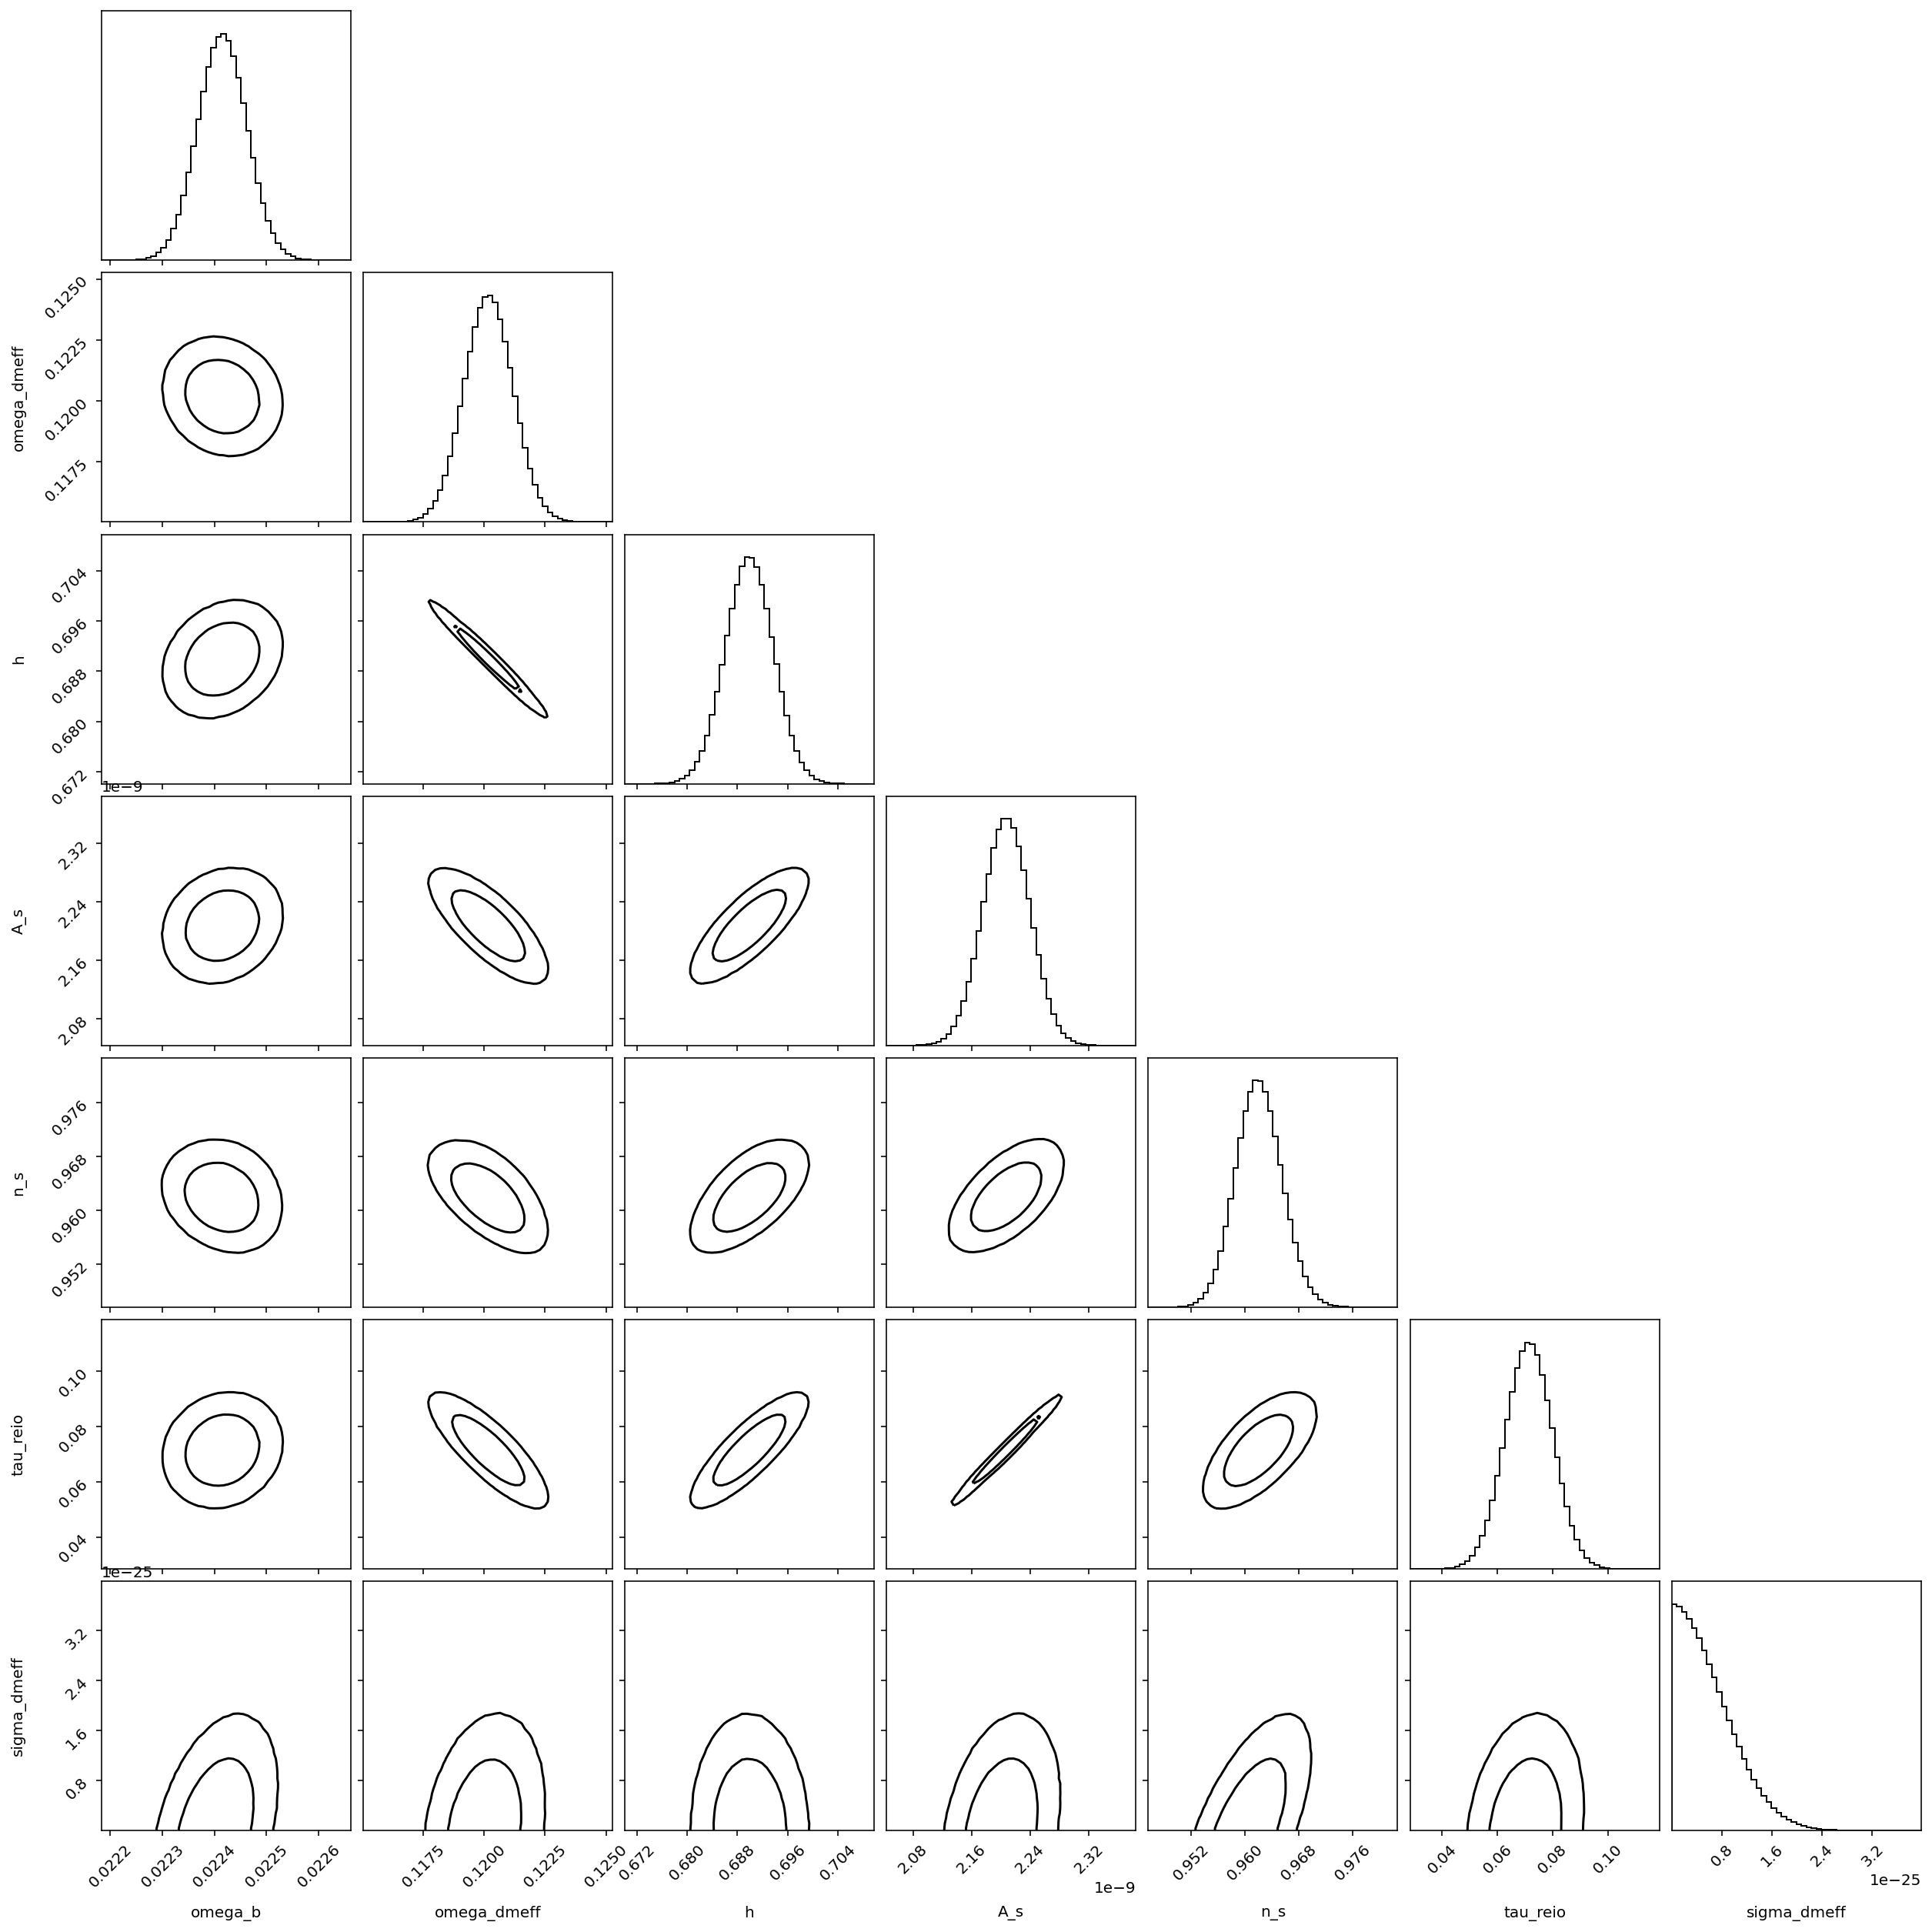

In [7]:
npar = cov.shape[0]
fig, ax = plt.subplots(npar, npar, figsize=(18,18))

corner.corner(unmodified_samples,
              plot_datapoints=False, plot_density=False, bins=50, 
              levels=(0.68,0.95), lw=2, fig=fig,
              hist_kwargs={'density':True}, labels=[r'omega_b', r'omega_dmeff', r'h',  r'A_s', r'n_s', r'tau_reio', 'sigma_dmeff']);


Now we can modify these samples. Let's change $\tau_{reio}$ into the parameter $\tau_{reio}^3$, and **also weight it by $\tau$**.

In [8]:
modified_samples = unmodified_samples.copy()
modified_samples.T[-1] = unmodified_samples.T[-1]**3 # change the last column (i.e. tau) 

In [9]:
modified_samples.T[-1]

array([2.54957754e-76, 5.25870057e-75, 6.52055626e-78, ...,
       1.86412023e-77, 7.43938568e-78, 2.69469536e-77])

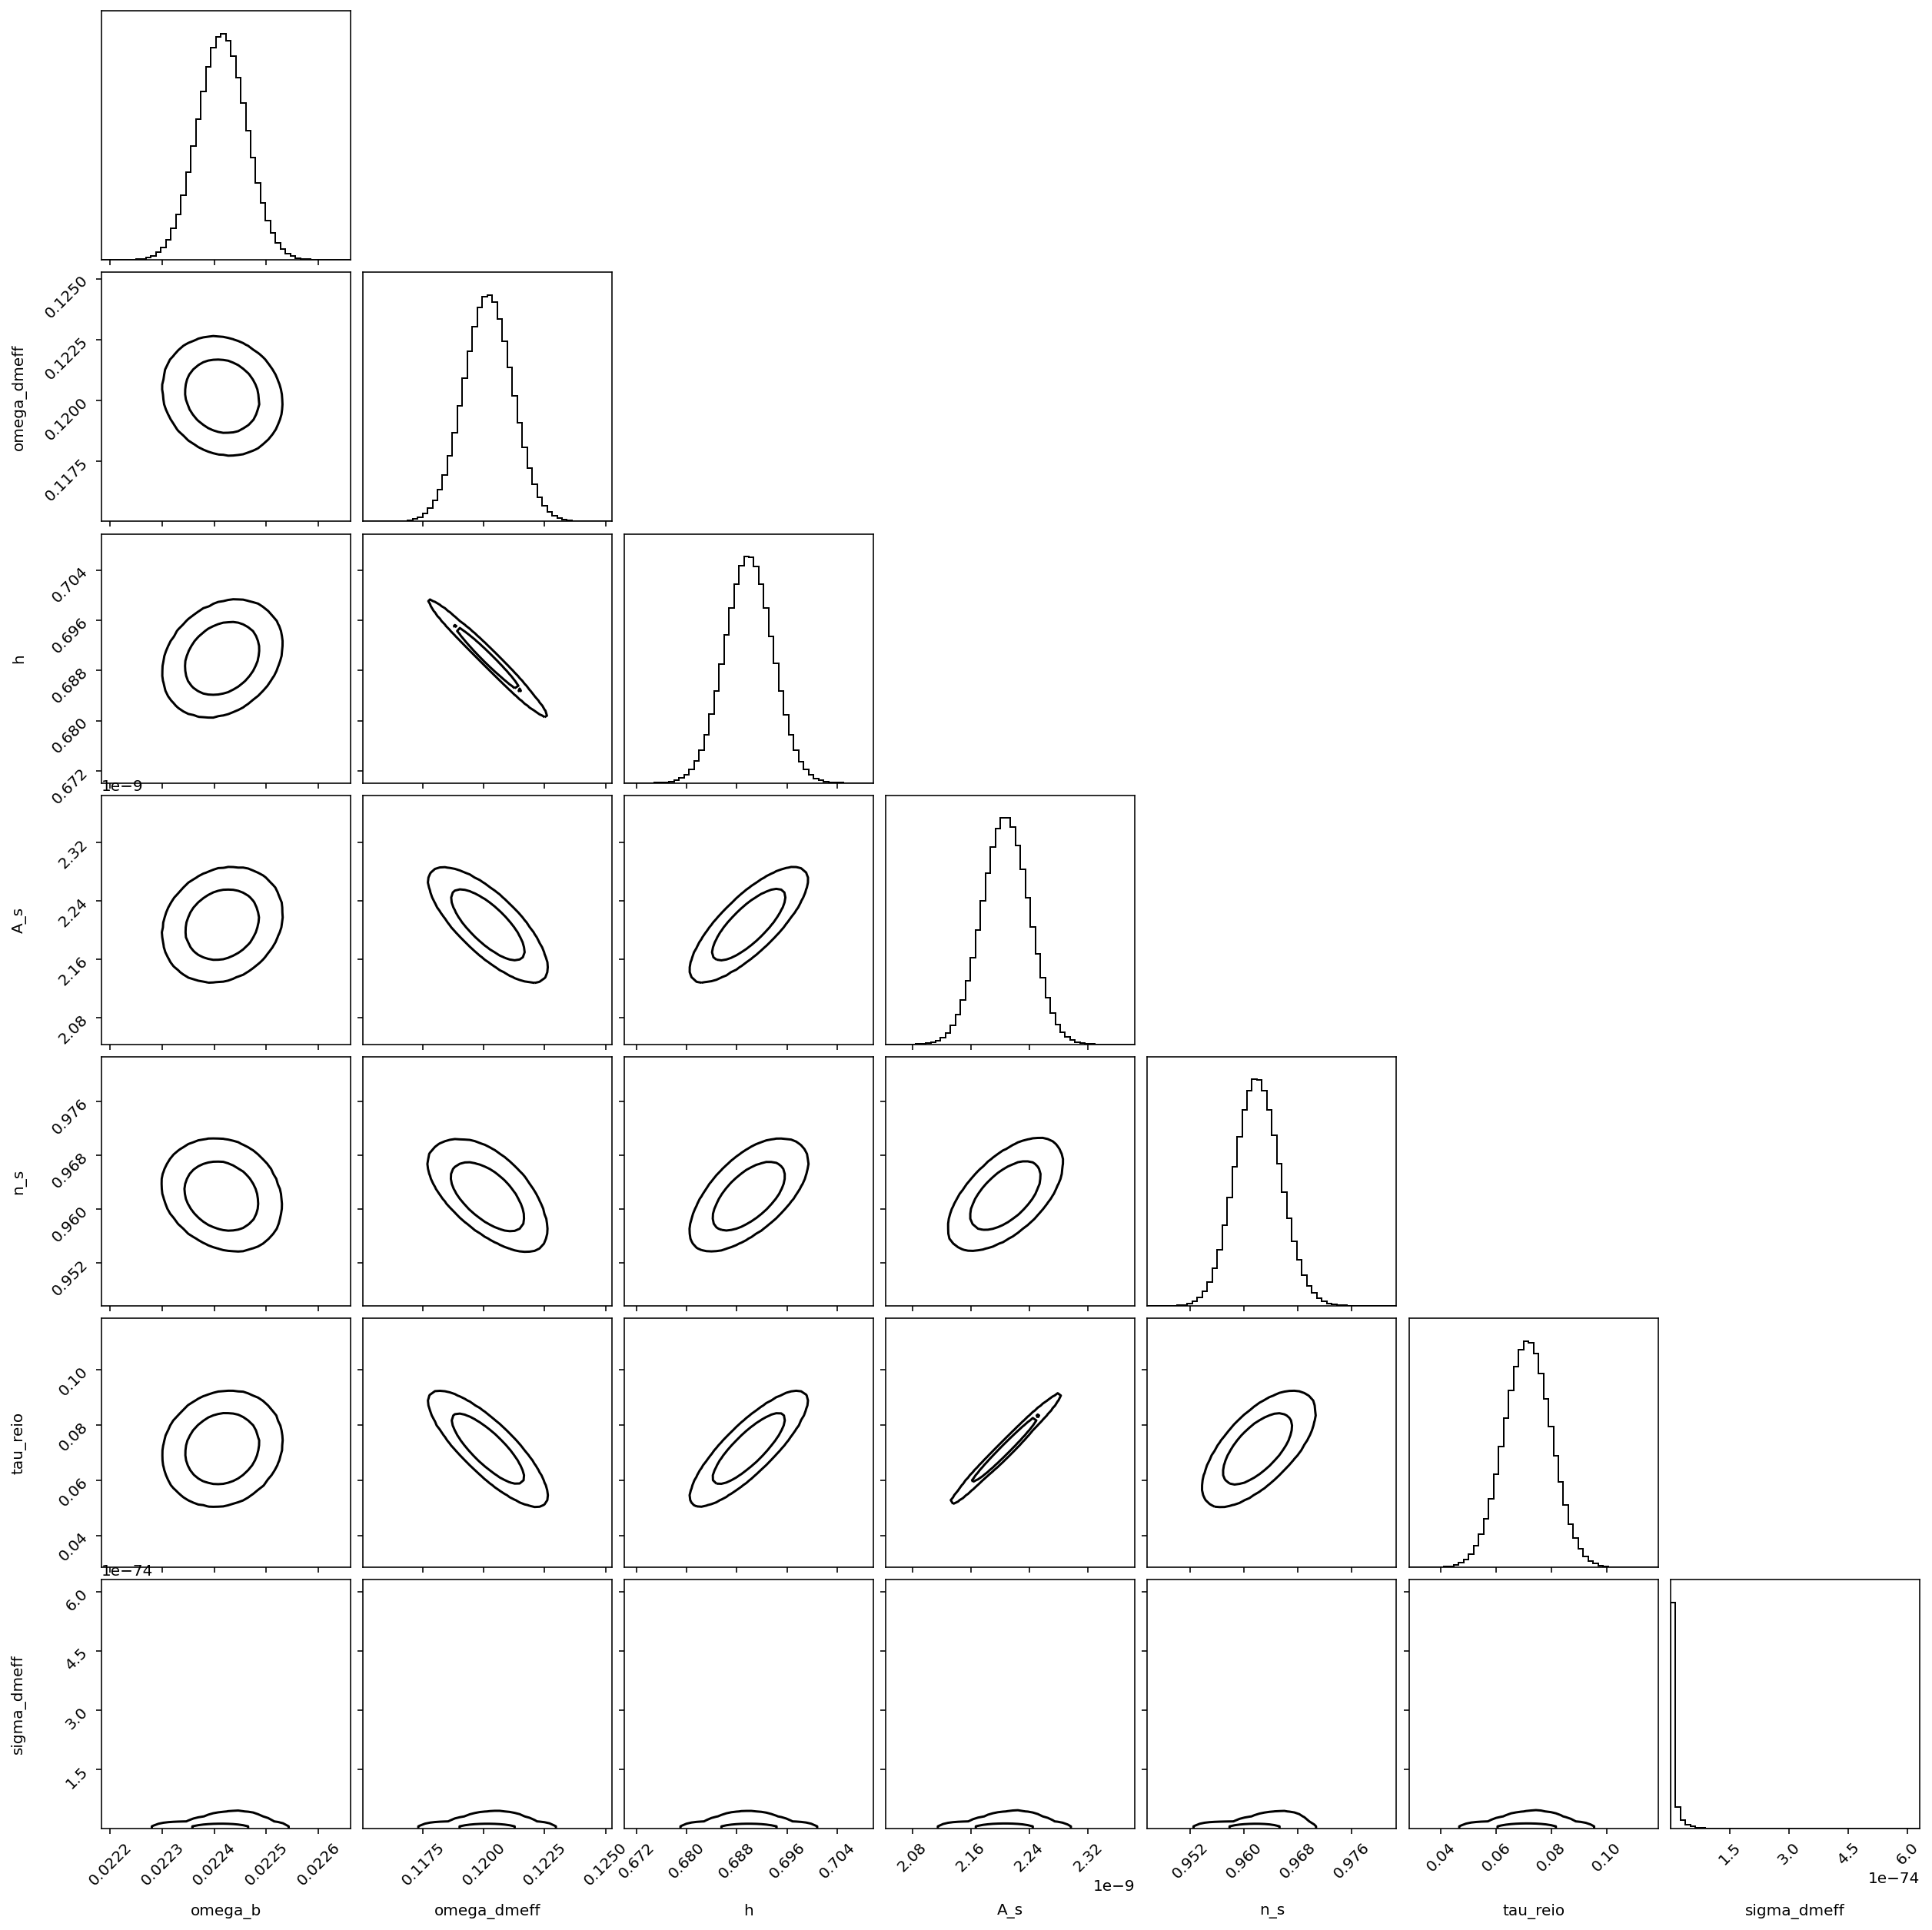

In [10]:
fig, ax = plt.subplots(npar, npar, figsize=(18,18))
corner.corner(modified_samples,
              plot_datapoints=False, plot_density=False, bins=50, 
              levels=(0.68,0.95), lw=2, fig=fig,
              hist_kwargs={'density':True}, labels=[r'omega_b', r'omega_dmeff', r'h',  r'A_s', r'n_s', r'tau_reio', 'sigma_dmeff'],
              
              weight=unmodified_samples.T[-1]); # the weight= allows for us to use a prior

What if we disallow $h < 0.69$ as well?

In [11]:
'''modified_samples = modified_samples[modified_samples.T[2]>0.69]

fig, ax = plt.subplots(npar, npar, figsize=(18,18))
corner.corner(modified_samples,
              plot_datapoints=False, plot_density=False, bins=50, 
              levels=(0.68,0.95), lw=2, fig=fig,
              hist_kwargs={'density':True}, labels=[r'omega_b', r'omega_dmeff', r'h',  r'A_s', r'n_s', r'tau_reio', 'sigma_dmeff'],
              
              weight=unmodified_samples.T[-1]); # the weight= allows for us to use a prior'''

"modified_samples = modified_samples[modified_samples.T[2]>0.69]\n\nfig, ax = plt.subplots(npar, npar, figsize=(18,18))\ncorner.corner(modified_samples,\n              plot_datapoints=False, plot_density=False, bins=50, \n              levels=(0.68,0.95), lw=2, fig=fig,\n              hist_kwargs={'density':True}, labels=[r'omega_b', r'omega_dmeff', r'h',  r'A_s', r'n_s', r'tau_reio', 'sigma_dmeff'],\n              \n              weight=unmodified_samples.T[-1]); # the weight= allows for us to use a prior"

Here are some possibly useful functions for your case!

In [12]:
def convert_to_cc_array(sig, mass_X):
    """utility function for converting sigma_p to the coupling constant
    
    Parameters
    ----------
        sig (float) : the cross section, sigma_p, possibly a numpy 
        mass_X (float) : dark matter particle mass in GeV
        
    Returns
    -------
        Numpy array that 
    """
    mp = 0.9382720813
    GeV = 1./(0.19732705e-15)
    cc_conversion = (1./( (246.22 * GeV)**4 * np.pi)) * \
        ( (mass_X * mp) / (mass_X + mp) * GeV )**2
    derived_cc = np.sqrt( sig / cc_conversion )
    return derived_cc


def get_95_exclusion(input_cov):
    """convenience function for turning a covariance matrix into a 95% exclusion.
    
    This function is specifically for the sigma_p case with a flat prior on the
    coupling, and positive definite cross section.
    
    Parameters
    ----------
        input_cov (numpy array) : covariance matrix
        
    Returns
    -------
        float, 95% upper limit for a fidcuial centered on zero
    """
    # NOTE: sigma_p MUST BE THE LAST VARIABLE
    samps = get_samps(input_cov, forecast_means_list, num=int(1e8))
    samps = samps[samps.T[-1]>0]
    onesig, twosig = corner.quantile(samps[:,-1], 
                                 [0.68,0.95], 
                                 weights=1./np.sqrt(samps.T[-1]))
    return twosig
    


You would run something like the following. (assuming that sigma_p is the last parameter in the list).


In [13]:
'''samps = get_samps(cov, centers, num=int(1e8)) # get the samples from the covariance
samps = samps[samps.T[-1]>0] # sigma_p cannot be negative
modified = samps.copy()
modified.T[-1] = convert_to_cc_array(modified.T[-1], 1.0) * 1e-6 # convert to 1e6 * cc
    
fig, ax = plt.subplots(npar, npar, figsize=(18,18))
corner.corner(modified,
              plot_datapoints=False, plot_density=False, bins=50, 
              levels=(0.68,0.95), lw=2, fig=fig,
              hist_kwargs={'density':True}, labels=[r'omega_b', r'omega_cdm', r'h',  r'A_s', r'n_s', r'tau_reio', r'coupling'],
              
              weight=1./np.sqrt(samps.T[-1])); # sqrt(sigma_p) prior'''

"samps = get_samps(cov, centers, num=int(1e8)) # get the samples from the covariance\nsamps = samps[samps.T[-1]>0] # sigma_p cannot be negative\nmodified = samps.copy()\nmodified.T[-1] = convert_to_cc_array(modified.T[-1], 1.0) * 1e-6 # convert to 1e6 * cc\n    \nfig, ax = plt.subplots(npar, npar, figsize=(18,18))\ncorner.corner(modified,\n              plot_datapoints=False, plot_density=False, bins=50, \n              levels=(0.68,0.95), lw=2, fig=fig,\n              hist_kwargs={'density':True}, labels=[r'omega_b', r'omega_cdm', r'h',  r'A_s', r'n_s', r'tau_reio', r'coupling'],\n              \n              weight=1./np.sqrt(samps.T[-1])); # sqrt(sigma_p) prior"

In [25]:
F =[[284204039.0767543, -61090369.72280999, -18905519.922594678, 664943834061087.5, 2923900.7579542357, -3006671.29823589, 2.4945144785170663e+28], [-61090369.72280999, 33622816.95499895, 7559676.117510259, -1284296922690555.5, -1298439.9203182878, 5676239.4292916255, -3.415822228775727e+27], [-18905519.922594678, 7559676.117510259, 1961322.399006683, -178541315817562.38, -308859.3071038075, 783619.8172712845, -3.735493013553054e+27], [664943834061087.6, -1284296922690555.5, -178541315817562.38, 1.7644176972670874e+23, 181959843022883.28, -774413885807301.8, -7.754229454842871e+36], [2923900.757954236, -1298439.9203182878, -308859.3071038075, 181959843022883.28, 404726.18212709005, -808524.0040377536, -1.348027456366911e+28], [-3006671.29823589, 5676239.4292916255, 783619.8172712845, -774413885807301.9, -808524.0040377537, 3468701.0449062972, 3.3988916023979692e+28], [2.4945144785170663e+28, -3.4158222287757293e+27, -3.735493013553054e+27, -7.754229454842874e+36, -1.348027456366911e+28, 3.3988916023979692e+28, 6.552630017438848e+50]]



In [26]:
import math
import numpy as np

cov = np.linalg.inv(F)
forecast_means_list = centers 

get_95_exclusion(cov)

3.0938920853523774e-25

In [16]:
get_samps(cov, centers, num=int(1e8))

array([[ 2.24617559e-02,  1.21508367e-01,  6.85891025e-01, ...,
         9.59937422e-01, -2.55691464e-01,  8.89316186e-26],
       [ 2.23874292e-02,  1.20579532e-01,  6.88262402e-01, ...,
         9.60869214e-01, -1.43906260e+00,  3.65499401e-26],
       [ 2.24549920e-02,  1.21618172e-01,  6.84980310e-01, ...,
         9.58208885e-01, -1.94362353e-01,  7.71719579e-26],
       ...,
       [ 2.23896933e-02,  1.21226341e-01,  6.85607457e-01, ...,
         9.58599489e-01, -5.38608877e-01,  2.73644875e-26],
       [ 2.24596605e-02,  1.20652981e-01,  6.87943930e-01, ...,
         9.56463961e-01,  1.08444331e+00,  1.32467305e-27],
       [ 2.24358690e-02,  1.20137754e-01,  6.89863393e-01, ...,
         9.59971991e-01, -1.57717852e-01,  1.97809800e-26]])